<a href="https://colab.research.google.com/github/cielo112/Oil-Portraits-Using-GAN/blob/main/art_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Description

The aim of this project is to develop a state-of-the-art Generative Adversarial Network (GAN) capable of generating realistic and visually appealing oil paintings. By harnessing the power of deep learning and computer vision, this project seeks to enable artists, designers, and art enthusiasts to effortlessly create digital oil paintings that mimic the aesthetic and style of traditional oil painting techniques.

The project will involve the following key steps:

* Data Collection: A comprehensive dataset of high-quality oil paintings will be curated. This dataset will consist of diverse styles, genres, and subjects, including landscapes, portraits, still life, and abstract art. Careful consideration will be given to ensure a wide range of artistic techniques, brush strokes, and color palettes are represented.

* Model Architecture Design: An innovative GAN architecture will be designed to learn the intricate details and artistic elements present in oil paintings. The generator network will be responsible for producing realistic and coherent oil painting images, while the discriminator network will evaluate the generated images for authenticity. Various architectural components, such as convolutional and recurrent layers, will be explored and optimized to enhance the final output quality.

* Training Process: The GAN model will be trained on the curated dataset using advanced optimization techniques such as adversarial training, where the generator and discriminator networks compete against each other, improving their performance iteratively. To mitigate common challenges like mode collapse and training instability, additional regularization techniques and loss functions will be incorporated.

* Style Transfer and Customization: The trained GAN model will enable users to transfer various artistic styles to their own images or create entirely new oil paintings from scratch. The model will allow users to adjust parameters such as brush strokes, color palettes, texture, and composition, providing a high level of customization and artistic control.

**Importing Libraries**

In [46]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tqdm
import warnings
import zipfile
import PIL
from PIL import Image
from skimage import io
warnings.filterwarnings("ignore")


**Loading the Data**

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od

od.download(
    'https://www.kaggle.com/datasets/karnikakapoor/art-portraits?select=Portraits'
)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: johncarlocielo
Your Kaggle Key: ··········


100%|██████████| 1.30G/1.30G [00:50<00:00, 27.8MB/s]


In [47]:
path = r'/content/art-portraits/Portraits'
image_size = (64, 64)  # Desired image size
batch_size = 64

In [48]:
batch_s = 64
#Import as tf.Dataset
data = tf.keras.preprocessing.image_dataset_from_directory(path,
          label_mode = None, batch_size = batch_s, image_size=image_size)

Found 4117 files belonging to 1 classes.


In [49]:
def show_image(data):
    '''This displays the image as the output'''
    fig, axs = plt.subplots(figsize=(15,10), nrows=3, ncols = 6)
    for i, images in zip(range(1,19),data.take(18)):
        axs = plt.subplot(3,6,i)
        axs.imshow(images[i].numpy().astype('uint8'))
        axs.axis('off')
    fig.tight_layout()

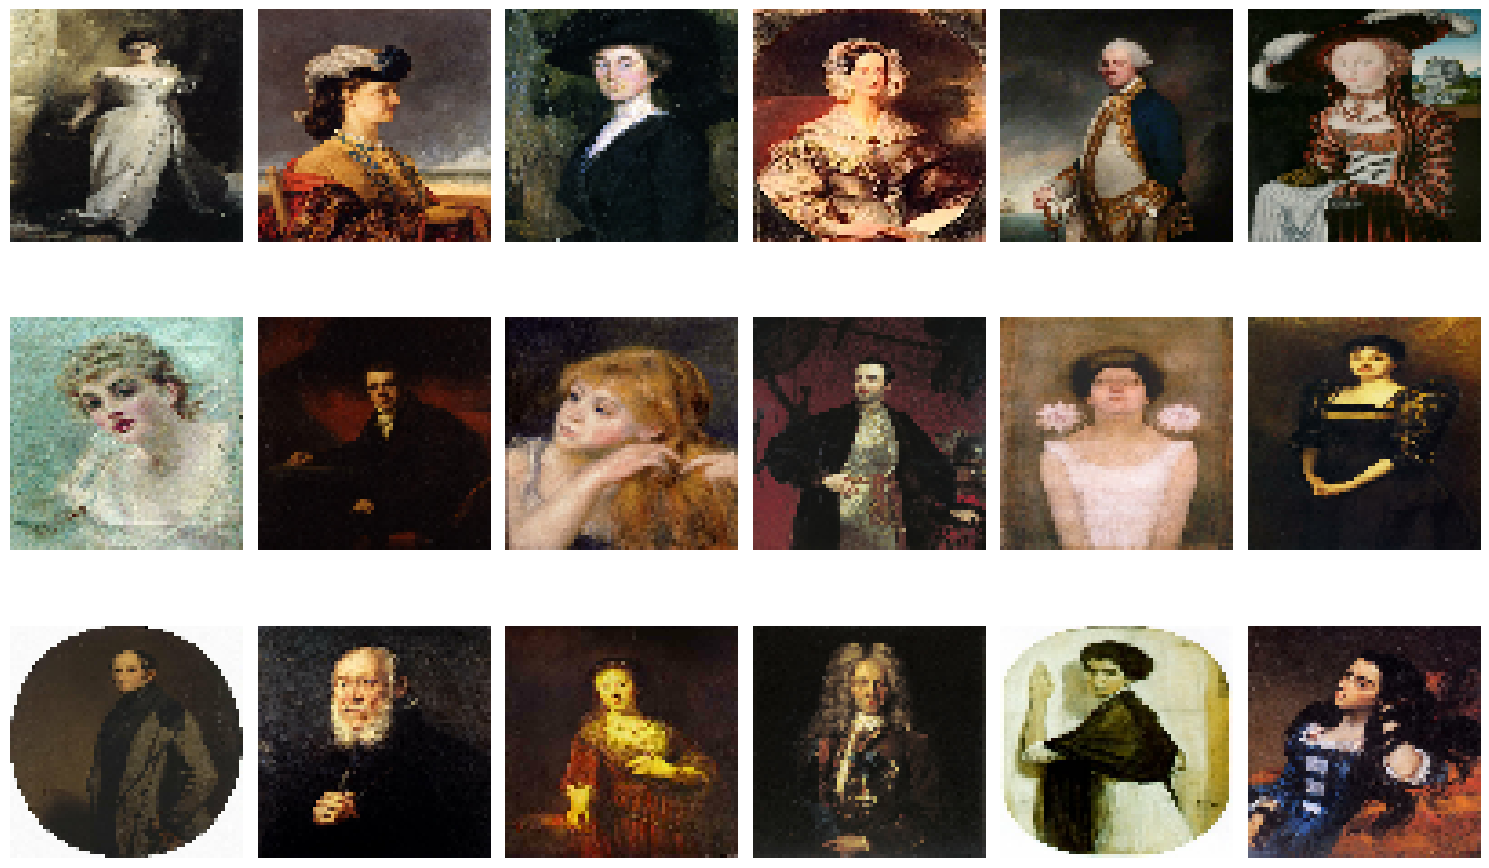

In [50]:
show_image(data)

In [51]:
data = data.map(lambda x: x/255.0)

# Building the GAN Model

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Dropout, ZeroPadding2D, Flatten, Activation
from tensorflow.keras.optimizers import Adam

In [54]:
def generator_builder(latent_dim, g_resolution):
    '''This function creates the generator model given the
    latent dimension and the resolution'''

    generator = Sequential()

    #takes random values and reshapes to 4,4,256 image
    generator.add(Dense(4*4*256, input_dim = latent_dim))
    generator.add(LeakyReLU(0.2))
    generator.add(Reshape((4,4,256)))

    generator.add(UpSampling2D())
    generator.add(Conv2D(256,3, padding='same'))
    generator.add(BatchNormalization(momentum=0.8))
    generator.add(LeakyReLU(0.2))

    generator.add(UpSampling2D())
    generator.add(Conv2D(256,3, padding='same'))
    generator.add(BatchNormalization(momentum=0.8))
    generator.add(LeakyReLU(0.2))

    generator.add(UpSampling2D())
    generator.add(Conv2D(256,3, padding='same'))
    generator.add(BatchNormalization(momentum=0.8))
    generator.add(LeakyReLU(0.2))

    generator.add(UpSampling2D())
    generator.add(Conv2D(128,3, padding='same'))
    generator.add(BatchNormalization(momentum=0.8))
    generator.add(LeakyReLU(0.2))


    generator.add(Conv2D(3,3, padding='same'))
    generator.add(Activation('tanh'))


    return generator

In [55]:
test_model = generator_builder(100, 2)

In [56]:
test_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape_2 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d_8 (UpSampling  (None, 8, 8, 256)        0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 8, 8, 256)         590080    
                                                                 
 batch_normalization_12 (Bat  (None, 8, 8, 256)        1024      
 chNormalization)                                     

In [57]:
generator = generator_builder(100,2)

(-0.5, 63.5, 63.5, -0.5)

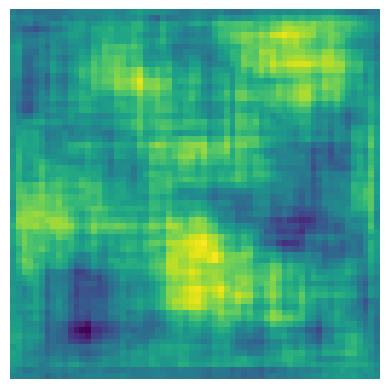

In [58]:
#Creating a random seed and output from generator
seed = tf.random.normal([1, 100])
Generated_Portrait = generator(seed, training=False)
#Plotting the image output of generator without training
plt.imshow(Generated_Portrait[0, :, :, 0])
plt.axis("off")

# Building the Discriminator

In [59]:
def discriminator_builder():
    '''This creates the discriminator for the GAN'''

    disc = Sequential()

    disc.add(Conv2D(32, 3, strides=2, input_shape=(64,64, 3), padding= 'same'))
    disc.add(LeakyReLU(0.2))
    disc.add(Dropout(0.25))

    disc.add(Conv2D(64,3, strides=2, padding='same'))
    disc.add(BatchNormalization(momentum=0.8))
    disc.add(LeakyReLU(0.2))
    disc.add(Dropout(0.25))

    disc.add(Conv2D(128,3, strides=2, padding='same'))
    disc.add(BatchNormalization(momentum=0.8))
    disc.add(LeakyReLU(0.2))
    disc.add(Dropout(0.25))

    disc.add(Conv2D(256,3, strides=2, padding='same'))
    disc.add(BatchNormalization(momentum=0.8))
    disc.add(LeakyReLU(0.2))
    disc.add(Dropout(0.25))

    disc.add(Conv2D(512,3, strides=2, padding='same'))
    disc.add(BatchNormalization(momentum=0.8))
    disc.add(LeakyReLU(0.2))
    disc.add(Dropout(0.25))


    disc.add(Flatten())
    disc.add(Dense(1, activation= 'sigmoid'))

    return disc

In [60]:
discriminator = discriminator_builder()
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 32, 32, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_20 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                      

# Gan Compilation

In [61]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model

In [27]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()

        #Create attributes for the discr and gen
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()

        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name='d_loss')
        self.g_loss_metric = tf.keras.metrics.Mean(name='g_loss')

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

        #generate the fake image
        generated_images = self.generator(seed)

        #combine generated image with the real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        #Assing labels to the generated and real images
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        #Add noise to the labels
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        #Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

         # Sample random points in the latent space
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}


**Model Training**

In [62]:
#Define the epochs to be run
epochs = 50

#Setting the optimizers and the loss functions
g_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
d_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
loss_fn = BinaryCrossentropy()
latent_dim = 100

#Defining the GAN model
model = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

#Compiling the GAN
model.compile(d_optimizer=d_opt, g_optimizer=g_opt, loss_fn=loss_fn)


#Fitting the GAN
hist = model.fit(data, epochs=epochs)

Epoch 1/50
65/65 [==============================] - 51s 585ms/step - d_loss: 0.6718 - g_loss: 0.7617
Epoch 2/50
65/65 [==============================] - 44s 610ms/step - d_loss: 0.6938 - g_loss: 0.7324
Epoch 3/50
65/65 [==============================] - 42s 557ms/step - d_loss: 0.6769 - g_loss: 0.7619
Epoch 4/50
65/65 [==============================] - 42s 555ms/step - d_loss: 0.6770 - g_loss: 0.7972
Epoch 5/50
65/65 [==============================] - 40s 554ms/step - d_loss: 0.6784 - g_loss: 0.7828
Epoch 6/50
65/65 [==============================] - 41s 559ms/step - d_loss: 0.6781 - g_loss: 0.7847
Epoch 7/50
65/65 [==============================] - 40s 552ms/step - d_loss: 0.6733 - g_loss: 0.8120
Epoch 8/50
65/65 [==============================] - 41s 554ms/step - d_loss: 0.6711 - g_loss: 0.8077
Epoch 9/50
65/65 [==============================] - 42s 591ms/step - d_loss: 0.6510 - g_loss: 0.8308
Epoch 10/50
65/65 [==============================] - 42s 590ms/step - d_loss: 0.6549 - g_lo

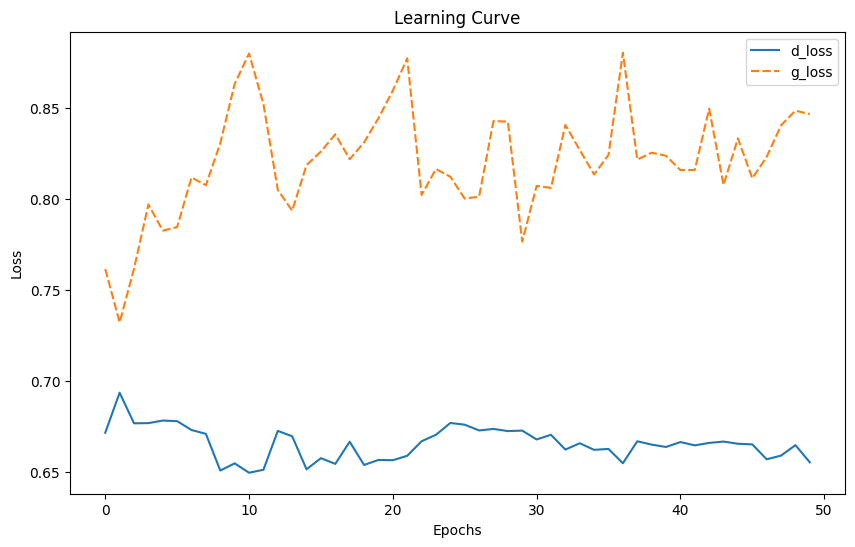

In [63]:
hist_df = pd.DataFrame(hist.history)
fig, axs =  plt.subplots(figsize=(10,6))
sns.lineplot(data=hist_df)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.show()

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
#Number of images to be generate
num_img=18

#A function to generate and save images
def Potrait_Generator(num_img, latent_dim):
    Generated_Paintings = []
    seed = tf.random.normal([num_img, latent_dim])
    generated_image = generator(seed)
    generated_image *= 255
    generated_image = generated_image.numpy()
    for i in range(num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_image[i])
            Generated_Paintings.append(img)
            img.save(f"{'/content/drive/MyDrive/Datasets/GAN Photos'}/label{i}.png")

    return Generated_Paintings

#Generating images
Images = Potrait_Generator(num_img=18, latent_dim=100)

In [68]:
#Loading generated images
generated_path = r'/content/drive/MyDrive/Datasets/GAN Photos'
portraits_generated = tf.keras.preprocessing.image_dataset_from_directory(generated_path, label_mode = None, batch_size=19)

Found 18 files belonging to 1 classes.


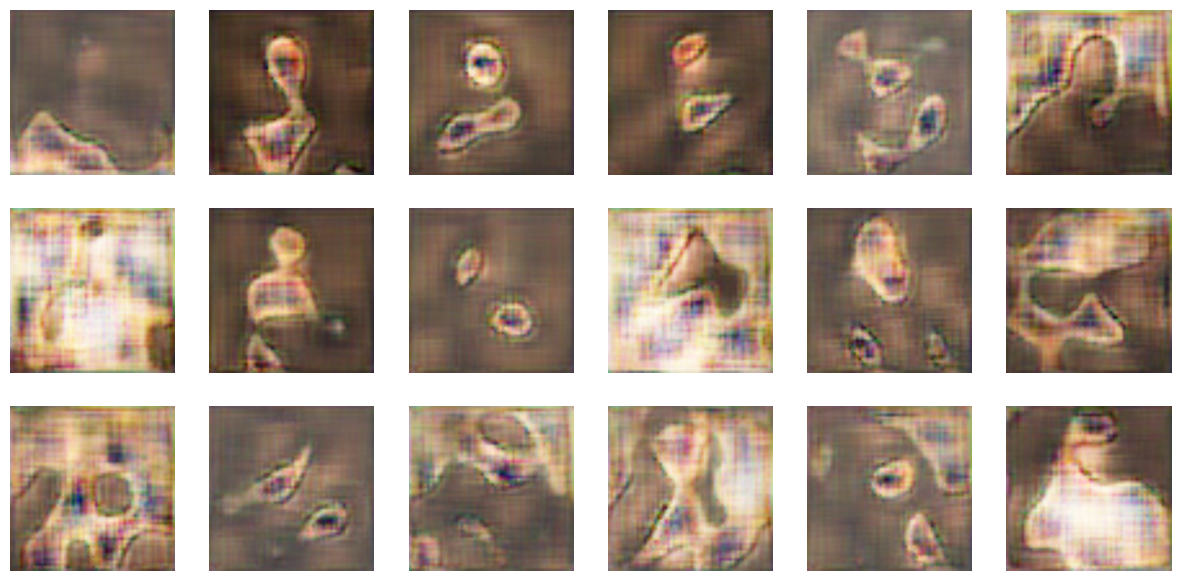

In [69]:
#Defing a function to see images
def Show_Img(data):
    plt.figure(figsize=(15,15))
    for images in data.take(1):
        for i in range(18):
            ax = plt.subplot(6, 6, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")
#Plotting the images in dataset
Show_Img(portraits_generated)